In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

import lstd
import test_utils
import trajgen

## I. Toy environments

In [3]:
p = 5
q = 3
Q, R = np.eye(p), np.eye(q)
sigma = 0.1

In [5]:
A, B = test_utils.random_env(p, q, Anorm=1.05)
Pstar = spl.solve_discrete_are(A, B, Q, R)
Kstar = -np.linalg.pinv(B.T @ Pstar @ B + R) @ (B.T @ Pstar @ A)

In [6]:
num_trajs = 10000
T = 10
xtrajs, utrajs, rtrajs = [], [], []
ctrl = test_utils.random_controller(q)
for _ in range(num_trajs):
    xtraj, utraj, rtraj = test_utils.sample_traj(A, B, Q, R, ctrl, T, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

### I-a. Policy evaluation

In [7]:
# Solve for a time-varying controller using value iteration
Pvi, Kvi = test_utils.lqr_vi(A, B, Q, R, 100, 0.99)
# Evaluate controller Kstar
Pxuhat, Pxhat = lstd.evaluate(traj, Kstar, 0.99, sigma=sigma)
test_utils.relerr(Pstar, Pxhat)

0.00534930607822644

### I-b. Policy Iteration

In [10]:
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, sigma=sigma, show_progress=False)

In [11]:
Tsim = 20
ctrl = test_utils.linear_feedback_controller(K)
ctrlopt = test_utils.linear_feedback_controller(Kstar)
xtraj, utraj, rtraj = test_utils.sample_traj(A, B, Q, R, ctrl, Tsim, sigma=0)
xopt, uopt, ropt = test_utils.sample_traj(A, B, Q, R, ctrlopt, Tsim, x0=xtraj[0], sigma=0)

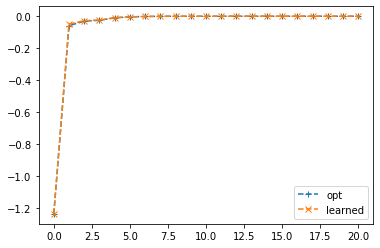

In [12]:
ind = 0
plt.plot(np.arange(Tsim+1), xopt[:, ind], '+--', label='opt')
plt.plot(np.arange(Tsim+1), xtraj[:, ind], 'x--', label='learned')
plt.legend()

## II. Tracking 2D min-snap trajectories on random linear dynamics

In [7]:
p = 2
q = 2
sigma = 0
A, B = test_utils.random_env(p, q, Anorm=0.99)
Q, R = 100 * np.eye(p), np.eye(q)
Tref = 10
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(A, B, Q, R, Tref)

In [24]:
# Solve for a static tracking controller by directly solving DARE
Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
static_opt_ctrl = test_utils.linear_feedback_controller(Kstar)
# Solve for dynamic tracking controller with VI
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, Tref)

### II-a Train a tracking controller

In [10]:
# Collect trajectory
ctrl = test_utils.random_controller(q)
num_trajs = 500
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
for _ in range(num_trajs):
    # Sample a reference trajectory
    #ref = test_utils.sample_ref_traj(p, T, order=8).flatten(order='F')
    ref = np.random.randn(p*(T+1))
    d0 = np.concatenate([np.zeros(p), ref])
    # Collect trajectory using random tracking controller
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, d0, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

In [11]:
# Train a tracking controller
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, max_iter=200, sigma=sigma)
learned_ctrl = test_utils.linear_feedback_controller(K)

  2%|██▌                                                                                                                                                                           | 3/200 [00:04<04:50,  1.47s/it]


### II-b Test tracking performance

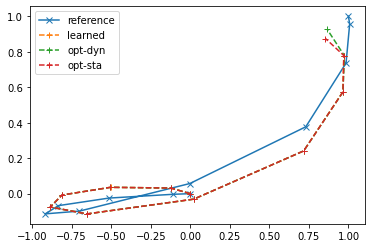

In [36]:
# Spline trajectory
x_waypoints = [0, np.random.randn(), np.random.randn(), 1]
y_waypoints = [0, np.random.randn(), np.random.randn(), 1]
ts = [0, 0.33, 0.66, 1]
order = 7

ref = np.vstack([trajgen.min_jerk(x_waypoints, ts, order, Tref)[1],
                 trajgen.min_jerk(y_waypoints, ts, order, Tref)[1]])
ref = ref.flatten(order='F')

d0 = np.concatenate([np.zeros(p), ref])
xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, learned_ctrl, Tref, d0, sigma=0)
xopt, uopt, ropt = test_utils.sample_traj(At, Bt, Qt, Rt, static_opt_ctrl, Tref, d0, sigma=0)
vi_ctrlr = test_utils.TVcontroller(Kvi[:])
xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

if p == 2:
    # Planar
    plt.plot(ref[0::2], ref[1::2], 'x-', label='reference')
    plt.plot(xtraj[:-1,0], xtraj[:-1, 1], '+--', label='learned')
    plt.plot(xvi[:,0], xvi[:, 1], '+--', label='opt-dyn')
    plt.plot(xopt[:,0], xopt[:, 1], '+--', label='opt-sta')
    plt.legend()

## III. Trajectory generation with dynamic regularization (1D)

In [11]:
p = 1
q = 1
sigma = 0
A, B = test_utils.random_env(p, q, Anorm=0.99)
Q, R = 10 * np.eye(p), np.eye(q)
Tref = 25
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(A, B, Q, R, Tref)
# Solve for a static tracking controller by directly solving DARE
Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
static_opt_ctrl = test_utils.linear_feedback_controller(Kstar)
# Solve for dynamic tracking controller with VI
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, Tref)

In [12]:
# Collect trajectory
ctrl = test_utils.random_controller(q)
num_trajs = 1000
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
for _ in range(num_trajs):
    ref = np.random.randn(p*(T+2))
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, ref, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

# Train a tracking controller
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, max_iter=50, sigma=sigma)
learned_ctrl = test_utils.linear_feedback_controller(K)
print('Relative error of value matrix is {:.3f}%'.format(test_utils.relerr(Pstar, P)*100))

 22%|██████████████████                                                                | 11/50 [01:35<05:49,  8.97s/it]

Relative error of value matrix is 7.027%


In [116]:
# Ref traj specifications
waypoints = [0, np.random.randn(), np.random.randn(), 1]
ts = [0, 0.33, 0.66, 1]

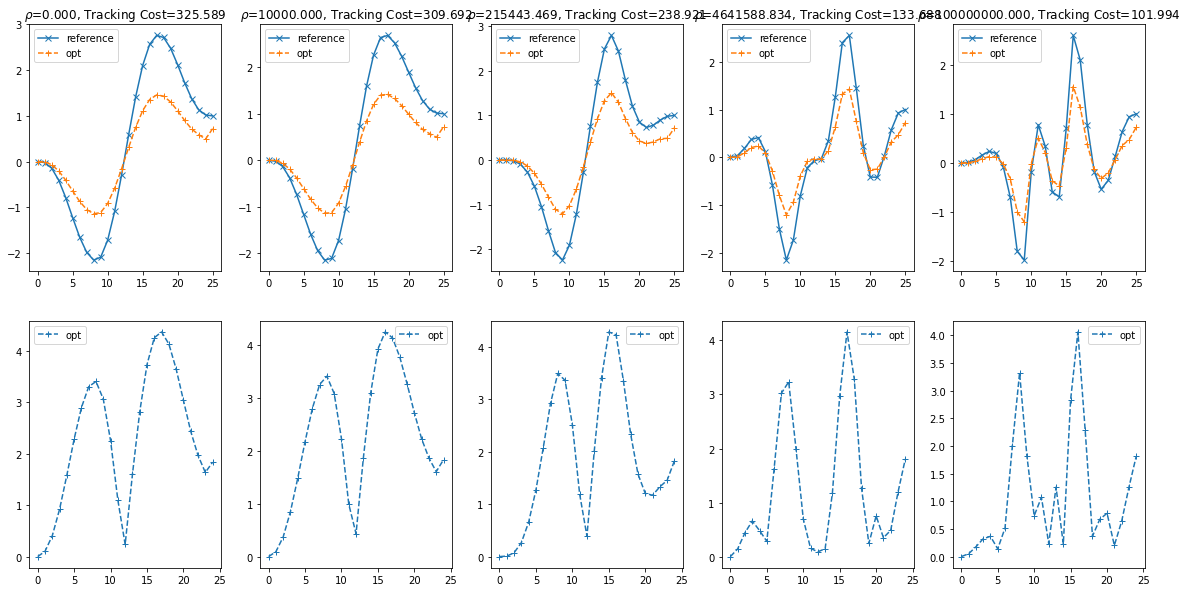

In [125]:
# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 4)])

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ref = trajgen.generate(waypoints, ts, 5, Tref+1, P=Pstar, rho=rho)
    d0 = np.concatenate([[waypoints[0]], ref])
    #xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, learned_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    plt.subplot(2, len(rhos), i+1)
    plt.plot(np.arange(Tref+1), ref, 'x-', label='reference')
    #plt.plot(np.arange(Tref+1), xtraj[:,0], '+--', label='learned')
    plt.plot(np.arange(Tref+1), xvi[:,0], '+--', label='opt')
    plt.legend()
    plt.title(r'$\rho$={:.3f}, Tracking Cost={:.3f}'.format(rho, rvi.sum()))
    
    plt.subplot(2, len(rhos), i+1+len(rhos))
    #plt.plot(np.arange(Tref), np.abs(utraj)[:,0], '+--', label='learned')
    plt.plot(np.arange(Tref), np.abs(uvi)[:,0], '+--', label='opt')
    plt.legend()

## Learning to track an underactuated 2D system

In [8]:
p = 2
q = 1
sigma = 0
A, B = test_utils.random_env(p, q, Anorm=0.99)
print(A)
print(B)
Q, R = 100 * np.eye(p), np.eye(q)
Tref = 25
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(A, B, Q, R, Tref)
# Solve for a static tracking controller by directly solving DARE
Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
static_opt_ctrl = test_utils.linear_feedback_controller(Kstar)
# Solve for dynamic tracking controller with VI
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, Tref)

[[ 0.25565583 -0.77498316]
 [-0.39093547  0.57742996]]
[[-0.69494673]
 [-1.14046482]]


In [9]:
# Collect trajectory
ctrl = test_utils.random_controller(q)
num_trajs = 5000
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
for _ in range(num_trajs):
    ref = np.random.randn(p*(T+2))
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, ref, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

In [10]:
_, P = lstd.evaluate(traj, Kstar, 0.99, sigma=sigma)
print('Relative error of value matrix is {:.3f}%'.format(test_utils.relerr(Pstar, P)*100))

Relative error of value matrix is 10.751%


In [6]:
# Train a tracking controller
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, max_iter=50, sigma=sigma)
learned_ctrl = test_utils.linear_feedback_controller(K)
print('Relative error of value matrix is {:.3f}%'.format(test_utils.relerr(Pstar, P)*100))

  8%|█████████████▊                                                                                                                                                              | 4/50 [11:42<2:14:35, 175.55s/it]

Relative error of value matrix is 8.624%


In [5]:
waypoints = [[0,0],
             [np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn()],
             [1,1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]
num_points = 20

In [36]:
%matplotlib inline

In [10]:
# Spline trajectory
Tref = 25
p = 2
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ref = trajgen.generate(waypoints, ts, 5, Tref+1, p, P=Pstar, rho=rho)
    print(ref)
    d0 = np.concatenate([waypoints[0], ref])
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, learned_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    #plt.subplot(3, len(rhos), i+1)
    #plt.plot(np.arange(Tref+1), ref.reshape(Tref+1, p), 'x-', label='reference')
    #plt.plot(np.arange(Tref+1), xtraj[:,:p], '+--', label='learned')
    #plt.plot(np.arange(Tref+1), xvi[:, :p], '+--', label='opt')
    #plt.legend()
    #plt.title(r'$\rho$={:.3f},\
    #          Tracking Cost={:.3f}'.format(rho, rvi.sum()))
    
    plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(ref[0::p], ref[1::p], 'x-', label='reference')
    plt.plot(xvi[:,0], xvi[:,1], '+-', label='tracking')
    plt.plot(xtraj[:,0], xtraj[:,1], '+-', label='learned')
    plt.plot(waypoints[:,0], waypoints[:,1], 'r^', label='waypoints')
    plt.legend()
    
    plt.subplot(3, len(rhos), i+1+2*len(rhos))
    plt.plot(np.arange(Tref), np.abs(utraj), '+--', label='learned')
    plt.plot(np.arange(Tref), np.abs(uvi), '+--', label='opt')
    plt.legend()

[-1.00756430e-08  1.32391191e-08  5.41088742e-04 -7.56627378e-03
  1.54447191e-03 -5.34996701e-02 -3.20401675e-03 -1.58735060e-01
 -2.52212981e-02 -3.29032706e-01 -7.91483704e-02 -5.59204831e-01
 -1.80571621e-01 -8.37342200e-01 -3.43844141e-01 -1.14904071e+00
 -5.79907035e-01 -1.48162797e+00 -8.60855197e-01 -1.77875616e+00
 -1.10350688e+00 -1.92169320e+00 -1.29560010e+00 -1.91650800e+00
 -1.42378202e+00 -1.78125512e+00 -1.47192846e+00 -1.53773632e+00
 -1.42315944e+00 -1.20877526e+00 -1.26185454e+00 -8.15492528e-01
 -9.75668848e-01 -3.74579883e-01 -5.78266216e-01  8.49003220e-02
 -1.93887744e-01  4.45809138e-01  1.50462216e-01  6.98121587e-01
  4.45059972e-01  8.58386324e-01  6.79990589e-01  9.47411884e-01
  8.48397007e-01  9.87474022e-01  9.49729155e-01  9.99523061e-01
  9.92993070e-01  1.00039122e+00  1.00000001e+00  9.99999987e-01]


NameError: name 'learned_ctrl' is not defined

<Figure size 1440x720 with 0 Axes>

## For a linearized quadrotor with decoupled subsystems, we run LSTD with disturbances in tracking

In [2]:
# Quadrotor system dynamics

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

import lstd
import test_utils
import trajgen

# define constants
g = 9.81 #m/s2
b = 0.01  # air drag/friction force
c = 0.2 #air friction constant

# quadrotor physical constants
m = 1.0  #kg  mass of the quadrotor
Ixx =0.5   # kg*m2 moment of inertia around X-axis (quadrotor rotates around X-axis)
Iyy =0.5   # kg*m2 
Izz =0.5   # kg*m2
Ktao =0.02           # Drag torque constant for motors
Kt =0.2             # Thrust constant for motors


# quadrotor geometry constants
t1 = np.pi/4   # rads
t2 = 3*np.pi/4  #rads
t3 = 5*np.pi/4 # rads
t4 = 7*np.pi/4 # rads
l = 0.2 #m  arm lenght from center of mass to each rotor


# X  axis dynamics
Ax = np.array(
[[0.0,1.0,0.0,0.0],
[0.0,0.0,g,0.0],
[0.0,0.0,0.0,1.0],
[0.0,0.0,0.0,0.0]])


Bx = np.array(
[[0.0],
[0.0],
[0.0],
[np.sin(t1)*l/Ixx]])

# X position output matrix
Cx = np.array([1.0,0.0,0.0,0.0])
# X velocity output matrix
Cx_dot = np.array([0.0,1.0,0.0,0.0])
# Pitch angle output matrix
Cp = np.array([0.0,0.0,1.0,0.0])
# Pitch angle velocity output matrix
Cp_dot = np.array([0.0,0.0,0.0,1.0])


# Y  dynamics
Ay = np.array(
[[0.0,1.0,0.0,0.0],
[0.0,0.0,-1.0*g,0.0],
[0.0,0.0,0.0,1.0],
[0.0,0.0,0.0,0.0]])

By = np.array(
[[0.0],
[0.0],
[0.0],
[np.sin(t1)*l/Iyy]])

# Y position output matrix
Cy = np.array([1.0,0.0,0.0,0.0])
# Y velocity output matrix
Cy_dot = np.array([0.0,1.0,0.0,0.0])
# Roll angle output matrix
Cr = np.array([0.0,0.0,1.0,0.0])
# Roll angle velocity output matrix
Cr_dot = np.array([0.0,0.0,0.0,1.0])


# Z axis dynamics
Az = np.array(
[[0.0,1.0],
[0.0,0.0]])

Bz = np.array(
[[0.0],
[1.0/m]])

# Z position output matrix
Cz = np.array([1.0,0.0])
# Z velocity matrix
Cz_dot = np.array([0.0,1.0])

# Yaw dynamics
Ayaw = np.array(
[[0.0,1.0],
[0.0,0.0]])

Byaw = np.array(
[[0.0],
[Ktao/(Kt*Izz)]]) 

# Yaw angle output matrix
Cyaw = np.array([1.0,0.0])
# Yaw angle velocity output matrix
Cyaw_dot = np.array([0.0,1.0])

# Transmission matrix
D = np.array([0.0])

In [3]:
p = 4
q = 1
sigma = 0

Qx, Rx = 100 * np.eye(p), np.eye(q)
Tref = 25
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(Ax, Bx, Qx, Rx, Tref)
# Solve for a static tracking controller by directly solving DARE
Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
static_opt_ctrl = test_utils.linear_feedback_controller(Kstar)
# Solve for dynamic tracking controller with VI
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, Tref)

In [5]:
# Collect trajectory
ctrl = test_utils.random_controller(q)
num_trajs = 5000
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
for _ in range(num_trajs):
    ref = np.random.randn(p*(T+2))
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, ref, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

In [6]:
waypoints = [[0, 0, 0, 0],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [1, 1, 1, 1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]
num_points = 20

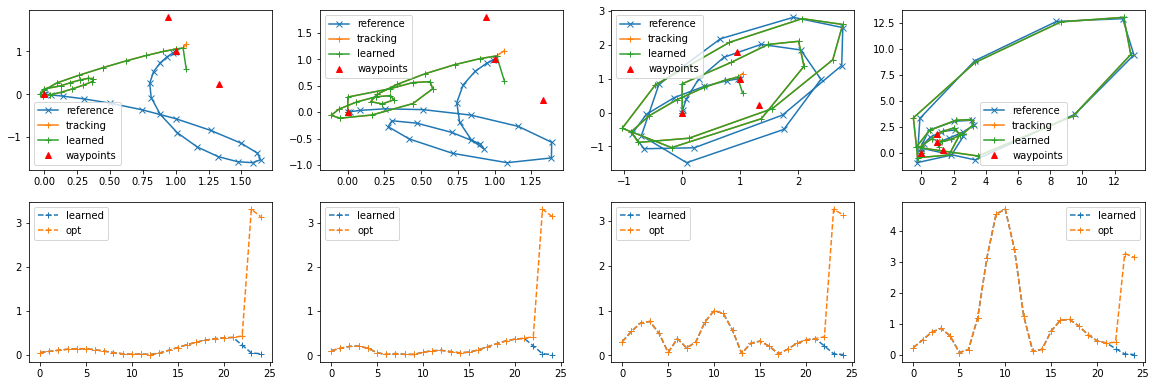

In [8]:
# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])


plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ref = trajgen.generate(waypoints, ts, 5, Tref+1, p, P=Pstar, rho=rho)
    d0 = np.concatenate([waypoints[0], ref])
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, static_opt_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    #plt.subplot(3, len(rhos), i+1)
    #plt.plot(np.arange(Tref+1), ref.reshape(Tref+1, p), 'x-', label='reference')
    #plt.plot(np.arange(Tref+1), xtraj[:,:p], '+--', label='learned')
    #plt.plot(np.arange(Tref+1), xvi[:, :p], '+--', label='opt')
    #plt.legend()
    #plt.title(r'$\rho$={:.3f},\
    #          Tracking Cost={:.3f}'.format(rho, rvi.sum()))
    
    plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(ref[0::p], ref[1::p], 'x-', label='reference')
    plt.plot(xvi[:,0], xvi[:,1], '+-', label='tracking')
    plt.plot(xtraj[:,0], xtraj[:,1], '+-', label='learned')
    plt.plot(waypoints[:,0], waypoints[:,2], 'r^', label='waypoints')
    plt.legend()
    
    plt.subplot(3, len(rhos), i+1+2*len(rhos))
    plt.plot(np.arange(Tref), np.abs(utraj), '+--', label='learned')
    plt.plot(np.arange(Tref), np.abs(uvi), '+--', label='opt')
    plt.legend()

In [ ]:
# _, P = lstd.evaluate(traj, Kstar, 0.99, sigma=sigma)
print('Relative error of value matrix is {:.3f}%'.format(test_utils.relerr(Pstar, P)*100))

# Train a tracking controller for 4 decoupled subsystems

In [46]:
# LQR Controller for x-subsystem

p = 4
q = 1

sigma = 0

Qx, Rx = 100*np.eye(p), np.eye(q)
Tref = 25
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(Ax, Bx, Qx, Rx, Tref)
print(At.shape)
print(Bt.shape)

Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
print(Pstar.shape)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
print(Kstar.shape)

static_ctrl = test_utils.linear_feedback_controller(Kstar)

"""num_trajs = 1000
T = Tref
xtrajs, utrajs, rtrajs = [], [], []
# Tvc = test_utils.linear_feedback_controller(Kstar)
ctrl = test_utils.random_controller(q)
for _ in range(num_trajs):
    ref = np.random.randn(p*(T+2))
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, ctrl, T, ref, sigma=sigma)
    xtrajs.append(xtraj)
    utrajs.append(utraj)
    rtrajs.append(rtraj)
traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)"""

# Solve for a time-varying controller using value iteration
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, 100, 0.99)
vi_ctrlr = test_utils.TVcontroller(Kvi[:])
# Evaluate controller Kstar
# Pxuhat, Pxhat = lstd.evaluate(traj, Kstar, 0.99, sigma=sigma)
# test_utils.relerr(Pstar, Pxhat)

(108, 108)
(108, 1)
(108, 108)
(1, 108)


In [26]:
# Generating x, y, z, yaw waypoints - Can skip yaw

waypoints = [[0, 0, 0, 0],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [1, 1, 1, 1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]
num_points = 20

In [7]:
%matplotlib inline

(26,)
(26,)
(26,)
(26,)


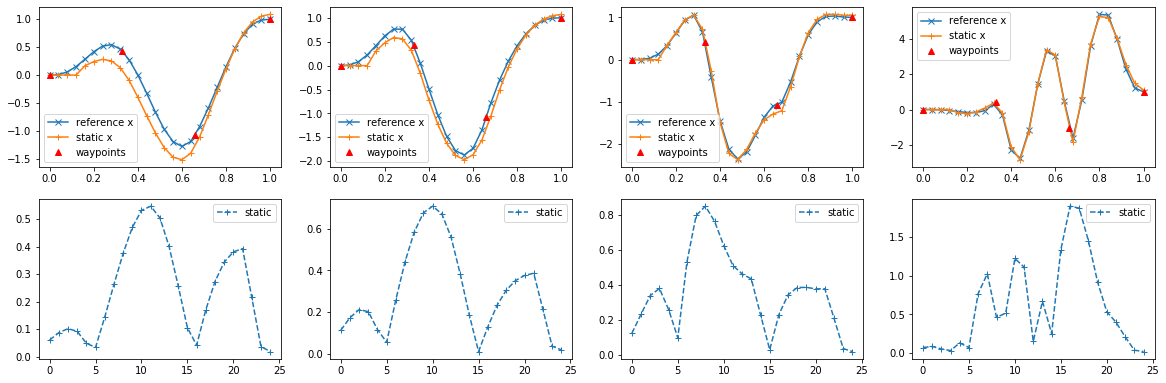

In [47]:
# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])
t = np.linspace(0, 1, 104)
tp = np.linspace(0, 1, 26)

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ref = trajgen.generate(waypoints, ts, 5, Tref+1, p, P=Pstar, rho=rho)
    d0 = np.concatenate([waypoints[0], ref])

    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, static_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(tp, ref[0::p], 'x-', label='reference x')
    # plt.plot(tp, xvi[:,0], '+-', label='tracking')
    plt.plot(tp, xtraj[:,0], '+-', label='static x')
    plt.plot(ts, waypoints[:, 0], 'r^', label='waypoints')
    plt.legend()
    
    plt.subplot(3, len(rhos), i+1+2*len(rhos))
    plt.plot(np.arange(Tref), np.abs(utraj), '+--', label='static')
    # plt.plot(np.arange(Tref), np.abs(uvi), '+--', label='opt')
    plt.legend()

In [56]:
# LQR Controller for y-subsystem

p = 4
q = 1

sigma = 0.1

Qx, Rx = 100*np.eye(p), np.eye(q)
Tref = 25
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(Ax, Bx, Qx, Rx, Tref)
print(At.shape)
print(Bt.shape)

Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
print(Pstar.shape)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)
print(Kstar.shape)

static_ctrl = test_utils.linear_feedback_controller(Kstar)

# Solve for a time-varying controller using value iteration
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, 100, 0.99)
vi_ctrlr = test_utils.TVcontroller(Kvi[:])

(108, 108)
(108, 1)
(108, 108)
(1, 108)


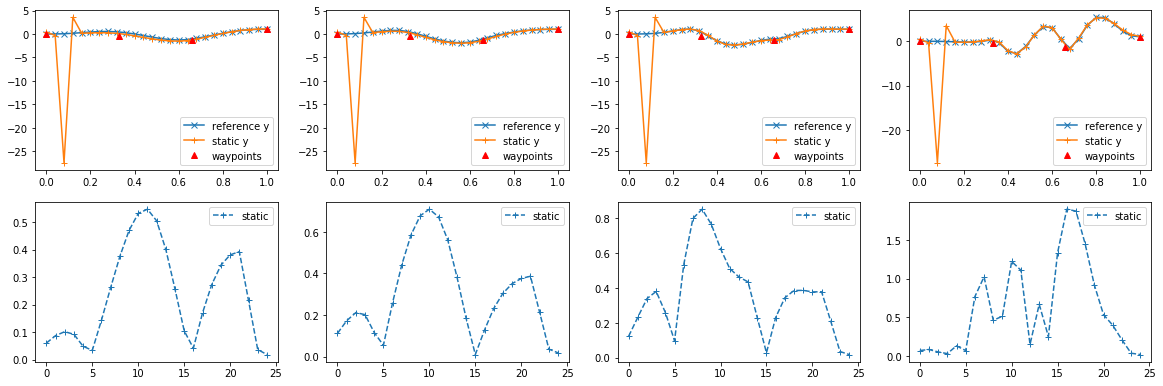

In [59]:
# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])
t = np.linspace(0, 1, 104)
tp = np.linspace(0, 1, 26)

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ref = trajgen.generate(waypoints, ts, 5, Tref+1, p, P=Pstar, rho=rho)
    d0 = np.concatenate([waypoints[1], ref])

    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, static_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)

    plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(tp, ref[0::p], 'x-', label='reference y')
    # plt.plot(tp, xvi[:,0], '+-', label='tracking')
    plt.plot(tp, xtraj[:, 0], '+-', label='static y')
    plt.plot(ts, waypoints[:, 1], 'r^', label='waypoints')
    plt.legend()
    
    plt.subplot(3, len(rhos), i+1+2*len(rhos))
    plt.plot(np.arange(Tref), np.abs(utraj), '+--', label='static')
    # plt.plot(np.arange(Tref), np.abs(uvi), '+--', label='opt')
    plt.legend()